In [ ]:
!pip install bettermoments
!pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.6 MB/s eta 0:00:00
  Created wheel for bettermoments: filename=bettermoments-1.8.5-py3-none-any.whl size=26712 sha256=07b17bf24620856ee1acc429e644f897e0f35db461e3343dfe4f306367ee5a78
  Stored in directory: /root/.cache/pip/wheels/a1/5b/6a/b855c9de63a02063f5b8b21c492bc9eb728954c152d18f92c0
Successfully built bettermoments


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 13.5 MB/s eta 0:00:00


In [ ]:
import bettermoments as bm
from astropy.io import fits
import numpy as np
import skimage
import skimage.transform
#!pip install imutils
#!pip install opencv-python
import cv2
import imutils
import matplotlib.pyplot as plt
import math
import seaborn as sb
import os
import glob as glob
import pandas as pd
import astropy.units as u
import photutils.aperture as phot
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from astropy.visualization import (AsymmetricPercentileInterval, AsinhStretch,ImageNormalize)
from matplotlib.patches import Ellipse
from matplotlib.cm import ScalarMappable
from astropy.stats import sigma_clipped_stats
import subprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Astro_object

In [ ]:
class astro_object():
    def __init__(self, name, image_dict, display_dict):
      #path

        #Set a path to the data directory
        self.name = name
        #self.path = path + "/" + name
        self.scattered_light = astro_image(image_dict['sl']) if image_dict['sl'] is not None else None
        self.sum_mm = astro_image(image_dict['mm']) if image_dict['mm'] is not None else None
        self.line = astro_image(image_dict['line']) if image_dict['line'] is not None else None

        self.imlist = [im for im in [self.scattered_light,self.sum_mm,self.line] if im is not None]

        self.zoom = display_dict['zoom']
        self.autobound = display_dict['autobound']

        for im in self.imlist:
          im.profiles()

#############################################################################

    def make_plot_multiline(self):

        '''
        profiles

        PURPOSE:
            #Calculate radial profile for a  disk at given PAs

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        sb.set(style = 'white',rc={"figure.figsize":(10, 12)})

        self.fig = plt.figure(constrained_layout=True)
        plt.suptitle("Multiwavelength Radial Profiles and High Resolution Imagery for " + self.name)

        from matplotlib.gridspec import GridSpec
        self.gs = GridSpec(4, len(self.imlist), figure=self.fig)

        # Create Radial and Azmuthal Profile Subplots
        rad_prof_ax = self.fig.add_subplot(self.gs[0, :])
        az_prof_ax = self.fig.add_subplot(self.gs[1, :])
        rad_az_prof_ax = self.fig.add_subplot(self.gs[2, :])

        # Create Image Subplots
        self.boundsize = 0


        if self.autobound:
            for index, im in enumerate(self.imlist):
                im_boundsize = im.auto_bound * im.pixscale
                if im_boundsize > self.boundsize:
                    self.boundsize = im_boundsize
        else:
            self.boundsize = self.zoom

        for index, im in enumerate(self.imlist):
            im_ax = self.fig.add_subplot(self.gs[3, index])

            bounds = {}
            if True:
                boundsize = int(round(self.boundsize/im.pixscale))
                bounds['x'] = [im.xcen - boundsize, im.xcen - boundsize/2, im.xcen + boundsize/2, im.xcen + boundsize]
                bounds['y'] = [im.ycen - boundsize, im.ycen - boundsize/2, im.ycen + boundsize/2, im.ycen + boundsize]
            else:
                bounds = im.bounds

            if im.r2:
                im.cropped_data = im.data[int(round(im.bounds['y'][0])):int(round(im.bounds['y'][3])),int(round(im.bounds['x'][0])):int(round(im.bounds['x'][3]))]
                im.norm_data = im.data/np.nanmax(im.cropped_data)
            else:
                im.norm_data = im.data/np.nanmax(im.data)

            im_show = im_ax.imshow(im.norm_data,
                             cmap = im.cmap, origin = 'lower',
                             norm = ImageNormalize(
                                 im.norm_data,
                                 #vmin = 0, vmax = 1,
                                 interval=AsymmetricPercentileInterval(im.interval[0],im.interval[1]),
                                 stretch=AsinhStretch(a=im.asinh_a)))

            plt.colorbar(im_show,label = 'Normalized Intensity',ax=im_ax,location = 'bottom')

            im_ax.set_xlim(bounds['x'][0],bounds['x'][3])
            im_ax.set_ylim(bounds['y'][0],bounds['y'][3])
            im_ax.set_xticks([bounds['x'][0],bounds['x'][1],im.xcen,bounds['x'][2],bounds['x'][3]])
            im_ax.set_xticklabels([str(round((val - im.xcen)*im.pixscale/1000,2)) + '"' for val in im_ax.get_xticks()])
            im_ax.set_yticks([bounds['y'][0],bounds['y'][1],im.ycen,bounds['y'][2],bounds['y'][3]])
            im_ax.set_yticklabels([str(round((val - im.ycen)*im.pixscale/1000,2)) + '"' for val in im_ax.get_yticks()])
            if im.imagery_type == 'line':
                im_type = "Line, Peak Intensity (Moment 8)"
            else:
                im_type = im.imagery_type
            im_ax.set_title(im.imagery_source + " " + im_type + "\n" + im.date)

            #str(im.PA)
            sb.lineplot(data = im.rad_plot_data.loc[im.rad_plot_data['PA'] == 'mean', :],
                        x = 'xaxis', y='flux',  marker = 'o', color = im.color,
                        label = im.imagery_type, ax=rad_prof_ax)#, alpha = 0.5)
            rad_prof_ax.axhline(y=0, color = 'black', ls = '--')
            sb.lineplot(data = im.az_plot_data.loc[(im.az_plot_data['Radius (mas)'].isin(im.radlist))&(im.az_plot_data['PA']!=str(im.PA))&(im.az_plot_data['PA']!=str(im.PA+90)), :],
                        x = 'PA', y='flux',  marker = 'o', color = im.color,
                        label = im.imagery_type, ax=az_prof_ax)#, alpha = 0.5)
            az_prof_ax.locator_params(axis='x', nbins=8)
            az_prof_ax.locator_params(axis='y', nbins=8)

            if im.imagery_type == "scattered light":
                im.radial_profiles['xaxis'] = im.radial_profiles['xaxis']
                im.rad_az_plot_data =  im.radial_profiles.drop([str(im.PA),str(im.PA+90), 'mean'], axis = 1).astype('float')
                im.rad_az_plot_data['xaxis'] = ([str(round(float(val))) for val in im.rad_az_plot_data['xaxis'].values])
                im.rad_az_plot_data = im.rad_az_plot_data.set_index('xaxis')
                sb.heatmap(im.rad_az_plot_data/np.nanmax(im.rad_az_plot_data),
                          cmap = im.cmap, cbar_kws= {'pad':0.001}, #self.norm = ImageNormalize(vmin = 0, vmax = 1, stretch=AsinhStretch(a = self.asinh_a))
                          vmin=0, vmax=1, ax = rad_az_prof_ax)
                rad_az_prof_ax.set_xlabel('Az (deg)')
                rad_az_prof_ax.set_ylabel('Rad (mas)')
                rad_az_prof_ax.locator_params(axis='x', nbins=8)
                # rad_az_prof_ax.set_ylim(42.5,0)
                # rad_az_prof_ax.set_ylim(20,1)
                rad_az_prof_ax.tick_params('y', labelrotation=0)
                # rad_az_prof_ax.set_yscale('log')



        #'Radial Profiles at PA = ' + "62" + "deg."
        rad_prof_ax.set(title = 'Azimuthally Averaged Radial Profiles', xlabel='Radius (mas)', ylabel= 'Normalized Intensity', xlim=(-0.1, self.zoom), ylim = (None,1))
        rad_prof_ax.legend(loc='upper right', title='Image Type')
        az_prof_ax.set(title = 'Azimuthal Profiles at Radius = ' + im.radlist[0] + 'mas', xlabel='Az (deg)', ylabel= 'Normalized Intensity', xlim=(-0.1, None), ylim = (None,1))
        az_prof_ax.legend(loc='upper right', title='Image Type')
        # az_prof_ax.locator_params(axis='x', nbins=8)


#Astro_image

In [ ]:
class astro_image():
    def __init__(self,image_dict):

        #Set a path to the data directory
        self.imagery_type = image_dict['type']
        self.imagery_source = image_dict['source']
        self.path = image_dict['path']

        self.trim = image_dict['trim']
        self.stokes_component = image_dict['stokes_component']

        self.r2 = image_dict['r2']
        self.background_sub = image_dict['background_sub']
        self.sigma_clip = image_dict['sigma_clip']
        self.deproject_data = True

        self.override_center = image_dict['override_center']

        self.dist = image_dict['dist (pc)']
        self.incl = image_dict['incl']
        self.PA = image_dict['PA']

        self.PAs = image_dict['PAs']
        self.PAs.append(self.PA)
        self.PAs.append(self.PA + 90)

        self.radstep = image_dict['radstep']
        self.radlist = image_dict['radlist']

        self.show_deltas = image_dict['show_deltas']
        self.plot = image_dict['plot']
        self.plot_types = image_dict['plot_types']

        self.zoom = image_dict['zoom']
        #self.interval = image_dict['perc_interval']
        self.interval = image_dict['perc_interval']
        self.asinh_a = image_dict['asinh_a']

        self.n_start = image_dict['n_start'] if image_dict['n_start'] is not None else image_dict['n_deltas']
        self.n_deltas = image_dict['n_deltas']
        self.delta_lim = image_dict['delta_lim']

        self.cmap = image_dict['cmap']
        self.color = image_dict['color']

        self.fits_table = fits.open(image_dict['path'])
        self.header = self.fits_table[0].header


##############################################################################
    def strip_header(self):
        header = self.fits_table[0].header
        if self.imagery_source == 'ALMA':
            self.date = header['DATE-OBS'].split('T')[0]
            self.target = header['OBJECT']
            self.pixscale = None
            for row in header['HISTORY']:
                if 'cell' in row:
                    #https://casaguides.nrao.edu/index.php?title=Image_Continuum#Image_Parameters
                    #self.pixscale = (float(row.split("= ['")[1].split("arcsec']")[0]) * u.arcsec).to(u.si.mas).value
                    self.pixscale = (float(row.split("cell")[1].split("=")[1].split("arcsec")[0].replace("'","").replace("[","").replace("]","")) * u.arcsec).to(u.si.mas).value
                    break
            if self.pixscale is None:
               self.pixscale = (abs(float(header['CDELT1'])) * u.deg).to(u.si.mas).value
            self.xcen,self.ycen = (header['CRPIX1'],header['CRPIX2'])
            self.resolution = (header['BMAJ'] + header['BMIN'])/2 * u.deg
            self.px_bin = int(np.floor(self.resolution.to(u.arcsec)/((self.pixscale * u.si.mas).to(u.arcsec))).value)
            self.units = header['BUNIT']

            if self.imagery_type == 'continuum':
                #conversion to float 64 required for image rotation later
                #https://github.com/quatrope/astroalign/issues/70
                self.data = skimage.util.img_as_float64(self.fits_table[0].data[0,0,:,:])

            if self.imagery_type == 'line':
                cube_data = self.fits_table[0].data
                if not math.isnan(self.trim):
                    trim = self.trim
                    data_trimmed = cube_data[0,trim[0][0]:trim[0][1],trim[1][0]:trim[1][1],trim[1][0]:trim[1][1]]
                    trimmed_path = self.path.split('.fits')[0] + '_trimmed.fits'
                    fits.writeto(trimmed_path, data_trimmed, header = file[0].header, overwrite = True)
                    newpath = trimmed_path
                else:
                    newpath = self.path
                if not os.path.exists(newpath.split('.fits')[0] + '_M8.fits'):
                  # bm_call = "bettermoments " + newpath + " -method eighth" # -clip 20
                  # call_output = subprocess.run(bm_call, shell=True)
                  moments = bm.collapse_zeroth(velax=velax, data=masked_data, rms=rms)
                new_file = fits.open(newpath.split('.fits')[0] + '_M8.fits')
                #conversion to float 64 required for image rotation later
                #https://github.com/quatrope/astroalign/issues/70
                self.data = skimage.util.img_as_float64(new_file[0].data[::]).byteswap().newbyteorder()

        if self.imagery_source == 'SPHERE':
            self.date = header['DATE']
            self.target = header["TARGET"]
            self.pixscale = header['SCALE']
            self.zeropt = header['ZEROPT']
            self.xcen,self.ycen = (header['STAR_X'],header['STAR_Y'])
            #Assuming North up, east left until told otherwise)
            #self.rot = 0

            stokes_index = header['STOKES'].split(',').index(self.stokes_component)
            #conversion to float 64 required for image rotation later
            #https://github.com/quatrope/astroalign/issues/70
            self.data = skimage.util.img_as_float64(self.fits_table[0].data[stokes_index])

            #https://courses.lumenlearning.com/suny-physics/chapter/27-6-limits-of-resolution-the-rayleigh-criterion/
            rayleigh_crit = 1.22 * (header['WAVELE'] * u.si.micron).to(u.meter)/(8.2 * u.meter) * u.si.rad
            self.resolution = rayleigh_crit
            self.px_bin = int(np.floor(rayleigh_crit.to(u.si.mas)/(self.pixscale * u.si.mas)))
            self.units = header['FLUXUNIT']

        if self.override_center is not None:
            self.xcen,self.ycen = self.override_center[0], self.override_center[1]
##############################################################################
    def deproject(self,r2=False):
        zoom = self.zoom

        ndimx,ndimy = self.data.shape[1],self.data.shape[0]
        halfx = int(round(self.xcen))
        halfy = int(round(self.ycen))
        half_px_bin = 1 #int(self.px_bin//2)

        # PA_mask = np.ones((ndimy,ndimx), dtype = 'int')
        # PA_mask[halfy-half_px_bin:halfy+half_px_bin+1,0:halfx] = 0
        # PA_mask[halfy:halfy+int(zoom/4),halfx-half_px_bin:halfx+half_px_bin+1] = 0


        # PA_mask = np.ma.make_mask(PA_mask)
        # print("Sum 1: " + str(np.sum(self.data)))
        #*PA_mask
        # fig, ax = plt.subplots()
        # im1 = ax.imshow((self.data*PA_mask)/np.nanmax((self.data)[halfx-zoom:halfx+zoom,halfy-zoom:halfy+zoom]),
        #                 origin = 'lower',
        #                 norm = ImageNormalize(
        #               (self.data)/np.nanmax((self.data)[halfx-zoom:halfx+zoom,halfy-zoom:halfy+zoom]),
        #               interval=AsymmetricPercentileInterval(30,100),
        #               stretch=AsinhStretch(a=0.01)))

        # ax.set_xlim(self.xcen-zoom,self.xcen+zoom)
        # ax.set_ylim(self.ycen-zoom,self.ycen+zoom)
        # plt.colorbar(im1,label = 'Normalized Intensity', ax = ax)
        #rotate so that PA of major axis is directly L/R
        #M = cv2.getRotationMatrix2D((self.ycen, self.xcen), self.PA - 90, 1.0)
        M = cv2.getRotationMatrix2D((self.xcen,self.ycen), self.PA - 90, 1.0)

        imrot = cv2.warpAffine(self.data, M,
                               (self.data.shape[0], self.data.shape[1]),
                               flags = cv2.INTER_CUBIC)
        # print("Sum 2: " + str(np.sum(imrot)))

        # fig, ax = plt.subplots()
        # im2 = ax.imshow(imrot/np.nanmax(imrot[halfx-zoom:halfx+zoom,halfy-zoom:halfy+zoom]), origin = 'lower',
        #           norm = ImageNormalize(imrot/np.nanmax(imrot[halfx-zoom:halfx+zoom,halfy-zoom:halfy+zoom]),
        #                                 vmin = 0,
        #                                 interval=AsymmetricPercentileInterval(30,100),
        #                                 stretch=AsinhStretch(a=0.01)))
        # plt.colorbar(im2,label = 'Normalized Intensity')
        # ax.set_xlim(self.xcen-zoom,self.xcen+zoom)
        # ax.set_ylim(self.ycen-zoom,self.ycen+zoom)

        #stretch image in y by cos(incl) to deproject and divide by that factor to preserve flux
        #https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d
        im_rebin = cv2.resize(imrot,
                              (ndimx,int(np.round(ndimy*(1/math.cos(math.radians(self.incl)))))),
                              interpolation = cv2.INTER_CUBIC)
        im_rebin = im_rebin/(1./math.cos(math.radians(self.incl)))

        ndimy2 = im_rebin.shape[0]
        if self.override_center is not None:
            print('override')
            ycen2 = int(round((ndimy2/ndimy)*self.ycen))
        else:
            ycen2 = ndimy2/2
        # print("Sum 3: " + str(np.sum(im_rebin)))
        # fig, ax = plt.subplots()
        # im3 = ax.imshow(im_rebin/np.nanmax(im_rebin[halfx-zoom:halfx+zoom,int(ycen2)-zoom:int(ycen2)+zoom]), origin = 'lower',
        #           norm = ImageNormalize(im_rebin/np.nanmax(im_rebin[halfx-zoom:halfx+zoom,int(ycen2)-zoom:int(ycen2)+zoom]),
        #                                 interval=AsymmetricPercentileInterval(30,100),
        #                                 stretch=AsinhStretch(a=0.01)))
        # ax.set_xlim(self.xcen-zoom,self.xcen+zoom)
        # ax.set_ylim(ycen2-zoom,ycen2+zoom)
        # plt.colorbar(im3,label = 'Normalized Intensity')

        if self.r2:
          print('applying r2 correction')
          r = np.zeros((ndimy2,ndimx))
          for x in np.arange(0, ndimx-1):
            for y in np.arange(0, ndimy2-1):
                r[y,x]=np.sqrt((x-self.xcen)**2+(y-ycen2)**2)
                im_rebin[y,x]=im_rebin[y,x]*(r[y,x])**2

        #rotate back to original orientation
        M = cv2.getRotationMatrix2D((self.xcen, ycen2), -1*(self.PA - 90), 1.0)
        #M = cv2.getRotationMatrix2D((ycen2,self.xcen), -1*(self.PA - 90), 1.0)

        im_rebin_rot = cv2.warpAffine(im_rebin, M,
                                      (ndimx, ndimy2),
                                      flags = cv2.INTER_CUBIC)

        # print("Sum 4: " + str(np.sum(im_rebin_rot)))
        # fig, ax = plt.subplots()
        # im4 = ax.imshow(im_rebin_rot/np.nanmax(im_rebin_rot[halfx-zoom:halfx+zoom,int(ycen2)-zoom:int(ycen2)+zoom]), origin = 'lower',
        #           norm = ImageNormalize(im_rebin_rot/np.nanmax(im_rebin_rot[halfx-zoom:halfx+zoom,int(ycen2)-zoom:int(ycen2)+zoom]),
        #                                 interval=AsymmetricPercentileInterval(30,100),
        #                                 stretch=AsinhStretch(a=0.01)))
        # ax.set_xlim(self.xcen-zoom,self.xcen+zoom)
        # ax.set_ylim(ycen2-zoom,ycen2+zoom)
        # plt.colorbar(im4,label = 'Normalized Intensity')

        self.data = im_rebin_rot
        self.ycen = ycen2
##############################################################################
    def pa_rotate(self):
        #PAs,nPAs,shape,data,xcen,ycen
        '''
        pa_rotate

        PURPOSE:
            #loop through PAs and rotate image so that that PA value is directly L/R

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        shape = (self.data.shape[0],self.data.shape[1])
        nPAs = len(self.PAs)
        file_rot = np.zeros((nPAs,shape[0],shape[1]))

        for i in np.arange(0, nPAs):
            pa = -self.PAs[i] + 90
            if pa == 0:
                file_rot[i] = self.data
            else:
                #https://snyk.io/advisor/python/imutils/functions/imutils.rotate
                #https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983
                M = cv2.getRotationMatrix2D((self.xcen, self.ycen), pa, 1.0)
                file_rot[i] = cv2.warpAffine(self.data,
                                             M,
                                             (shape[1], shape[0]),
                                             flags =    cv2.INTER_CUBIC)
            # fig, ax = plt.subplots()
            # im6 = ax.imshow((file_rot[i])/np.nanmax((file_rot[i])[int(self.xcen)-self.zoom:int(self.xcen)+self.zoom,int(self.ycen)-self.zoom:int(self.ycen)+self.zoom]),
            #               origin = 'lower',
            #               norm = ImageNormalize((file_rot[i])/np.nanmax((file_rot[i])[int(self.xcen)-self.zoom:int(self.xcen)+self.zoom,int(self.ycen)-self.zoom:int(self.ycen)+self.zoom]),
            #                                     interval=AsymmetricPercentileInterval(30,90), vmin = 0,
            #                                     stretch=AsinhStretch(a=0.01)))
            # ax.set_xlim(self.xcen-self.zoom,self.xcen+self.zoom)
            # ax.set_ylim(self.ycen-self.zoom,self.ycen+self.zoom)
            # plt.suptitle(self.PAs[i])
            # plt.colorbar(im6)

            # fig, ax = plt.subplots()
            # im5= ax.imshow(file_rot[i], origin = 'lower')
            #plt.colorbar(im5,label = 'Normalized Intensity')


        self.file_rot = file_rot
##############################################################################
    def make_profiles(self):

        '''
        make_profiles

        PURPOSE:
            #Calculate radial profile for a disk at given PAs

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        radial_profiles = pd.DataFrame(columns=[str(PA) for PA in self.PAs])
        azimuthal_angles = np.arange(0,360)
        azimuthal_profiles = pd.DataFrame(columns=[str(PA) for PA in self.PAs])
        shape = self.file_rot.shape[1:]
        halfx = int(shape[1]/2)
        halfy = int(shape[0]/2)
        half_px_bin = int(self.px_bin//2)

        PA_mask = np.ones(shape, dtype=bool)
        PA_mask[halfy:shape[0],halfx-half_px_bin:halfx+half_px_bin+1] = False

        # fig, ax = plt.subplots()
        # im4 = ax.imshow(self.file_rot[0], origin = 'lower')
        # plt.colorbar(im4)

        # fig, ax = plt.subplots()
        # im6 = ax.imshow(PA_mask, origin = 'lower')
        # plt.colorbar(im6)

        #print(self.xcen,self.ycen)

        for radcut in np.arange(0,(shape[0]/2/self.n_deltas)):
            #r_in,r_out = ((radcut if radcut>0 else 0.001) * px_bin, (radcut+1) * px_bin)
            r_in,r_out = (radcut * self.px_bin, (radcut+1) * self.px_bin)
            ap = (phot.CircularAnnulus([self.xcen,self.ycen], r_in, r_out)) if radcut > 0 else(phot.CircularAperture([self.xcen,self.ycen],r_out))

            for panum,pa in np.ndenumerate(self.PAs):
                radial_profiles.loc[radcut, str(pa)] = phot.ApertureStats(self.file_rot[panum],
                                                                          ap, sum_method = 'center',
                                                                          mask = PA_mask).median #mask = PA_mask + np.where(self.file_rot[panum]<0, True,False)).mean
            deltas = []
            delta_lim = self.delta_lim
            if len(radial_profiles) > self.n_start:
                if self.r2:
                    delta_lim = self.delta_lim * (radcut+1 * self.px_bin)**2
                for i in np.arange(0,self.n_deltas):
                    deltas.append(np.max(abs(radial_profiles.loc[radcut-(i+1),:] - radial_profiles.loc[radcut-i,:])))
                clip_condition = all(delta < delta_lim for delta in deltas)
                if self.show_deltas:
                    print(radial_profiles.loc[radcut,:])
                    print(deltas)
                    print(delta_lim)
                if self.r2:
                    clip_condition = bool(clip_condition + (np.where(radial_profiles.loc[radcut-self.n_deltas:radcut+1,:] < 0, True,False).all()))
                if clip_condition:
                    break

        for panum,pa in np.ndenumerate(self.PAs):
            for rad in np.arange(self.radstep,radcut*self.pixscale*self.px_bin,self.radstep, dtype=int).tolist():
                r_in,r_out = (int(rad/self.pixscale - half_px_bin),int(rad/self.pixscale + half_px_bin + 1))
                ap = phot.CircularAnnulus([self.xcen,self.ycen],r_in,r_out) if r_in > 0 else phot.CircularAperture([self.xcen,self.ycen],r_out)
                azimuthal_profiles.loc[str(rad), str(pa)] = phot.ApertureStats(self.file_rot[panum],
                                                                    ap, sum_method = 'center',
                                                                    mask = PA_mask).median  #mask = PA_mask + np.where(self.file_rot[panum]<0, True,False)).sum

        self.radial_profiles = radial_profiles
        self.azimuthal_profiles = azimuthal_profiles
        self.n_cuts = radcut + 1
##############################################################################
    def plot_prep(self):
        '''
        profiles

        PURPOSE:
            #Calculate radial profile for a disk at given PAs

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        self.auto_bound = self.n_cuts * self.px_bin
        self.bounds = {}
        self.bounds['x'] = [self.xcen - self.auto_bound, self.xcen - self.auto_bound/2, self.xcen + self.auto_bound/2, self.xcen + self.auto_bound]
        self.bounds['y'] = [self.ycen - self.auto_bound, self.ycen - self.auto_bound/2, self.ycen + self.auto_bound/2, self.ycen + self.auto_bound]

        #make x axis in arcsec
        self.radial_profiles['xaxis'] = np.arange(0,self.n_cuts) * self.pixscale * self.px_bin + self.pixscale * self.px_bin/2
        #add a second x axis in AU
#         if self.dist is not None:
#             xaxis2=np.tan(xaxis/206265.)*dist*206265.
#             if xmin is not None:
#                 xmin2=math.tan(xmin/206265.)*dist*206265.
#             else: xmin2=0
#             xmax2=np.tan(pixscale*n_cuts*px_bin/206265.)*dist*206265.

        #syms=[6,5,2,1,4,7,9,11,33]

        #colors = ['blue', 'green', 'purple', 'pink'] if irs48 is not None else 250/(nPAs-1) * np.arange(0,nPAs)
#         if ymax is not None:
#             ymaxm = ymax if ymax is not None else max(profiles)*1.1

        #xsty = 9 if dist is not None else 1

        #yttl = 'Intensity in mJy/arcsec!U2!N' if dist is not None else 'Normalized Intensity'
        # print('columns')
        # print(self.radial_profiles.loc[:, ~self.radial_profiles.columns.isin([str(self.PA), str(self.PA+90), 'xaxis'])].columns)
        self.radial_profiles['mean'] = self.radial_profiles.loc[:, ~self.radial_profiles.columns.isin([str(self.PA), str(self.PA+90),'xaxis'])].mean(axis= 1,skipna=True)
        rad_plot_data = pd.melt(self.radial_profiles, id_vars=['xaxis'], var_name='PA', value_name = 'flux')
        rad_plot_data['flux'] = rad_plot_data['flux']/np.nanmax(rad_plot_data['flux'])


        # print(self.azimuthal_profiles)
        # print(self.pixscale)
        # print(self.px_bin)
        self.azimuthal_profiles.loc[-1] = self.radial_profiles.loc[:, ~self.radial_profiles.columns.isin([str(self.PA), str(self.PA+90),'xaxis'])].median(axis= 0,skipna=True)
        self.azimuthal_profiles.rename(index={-1:'median'},inplace=True)
        self.azimuthal_profiles['Radius (mas)'] = self.azimuthal_profiles.index
        az_plot_data = pd.melt(self.azimuthal_profiles, id_vars=['Radius (mas)'], var_name='PA', value_name = 'flux')
        az_plot_data['flux'] = az_plot_data['flux']/np.nanmax(az_plot_data['flux'])


        self.rad_plot_data = rad_plot_data
        self.az_plot_data = az_plot_data
##############################################################################
    def make_plot(self):
      #(rad_plot_data,az_plot_data,image,zoom,xcen,ycen,pixscale,date,target,cmap,units,datasource)

        '''
        profiles

        PURPOSE:
            #Calculate radial profile for a disk at given PAs

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        from matplotlib.gridspec import GridSpec

        self.norm = ImageNormalize(vmin = 0, vmax = 1, stretch=AsinhStretch(a = self.asinh_a))

        sb.set(style = 'white',rc={"figure.figsize":(12, 4)})
        plt.rc('font', size=15) #controls default text size
        plt.rc('axes', titlesize=20) #fontsize of the title
        # plt.rc('axes', labelsize=15) #fontsize of the x and y labels
        # plt.rc('xtick', labelsize=15) #fontsize of the x tick labels
        # plt.rc('ytick', labelsize=15) #fontsize of the y tick labels
        # plt.rc('legend', fontsize=15) #fontsize of the legend
        fig = plt.figure(constrained_layout=True, figsize=(12,4))
        nplots = len(self.plot_types)
        axlist = []
        if nplots > 0:
            gs = GridSpec(nplots, 3, figure=fig)
            # create sub plots as grid
            ax1 = fig.add_subplot(gs[:, 0])
            ax2 = fig.add_subplot(gs[0, 1:])
            axlist.append(ax2)
            if nplots == 2:
                ax3 = fig.add_subplot(gs[1,1:])
                axlist.append(ax3)
        else:
            ax1 = fig.add_subplot(111)
        for ax in axlist:
            if 'rad' in self.plot_types:
                self.make_rad_plot(ax)

            if 'az' in self.plot_types:
                self.make_az_plot(ax)

            if 'heatmap' in self.plot_types:
                self.make_rad_az_plot(ax)

        self.make_im_plot(ax1)


        plt.suptitle("The Circumstellar Disk of "+self.target + " Imaged by " + self.imagery_source + " on " + self.date)
##############################################################################
    def make_im_plot(self, ax):
        cropped_max = np.nanmax(self.data[int(self.bounds['y'][0]):int(self.bounds['y'][3]),int(self.bounds['x'][0]):int(self.bounds['x'][3])])
        im = ax.imshow(self.data/cropped_max,
                        cmap = self.cmap,
                        origin = 'lower',
                        norm = self.norm)

        # ImageNormalize(
        #                     self.data/cropped_max,
        #                     vmin = 0, vmax = 1,
        #                     interval=AsymmetricPercentileInterval(self.interval[0],self.interval[1]),
        #                     stretch=AsinhStretch(a = self.asinh_a))
        ax.set_xlim(self.bounds['x'][0],self.bounds['x'][3])
        ax.set_ylim(self.bounds['y'][0],self.bounds['y'][3])
        ax.set_xticks([self.bounds['x'][0],self.bounds['x'][1],self.xcen,self.bounds['x'][2],self.bounds['x'][3]])
        ax.set_xticklabels([str(round((val - self.xcen)*self.pixscale/1000,2)) + '"' for val in ax.get_xticks()])
        ax.set_yticks([self.bounds['y'][0],self.bounds['y'][1],self.ycen,self.bounds['y'][2],self.bounds['y'][3]])
        ax.set_yticklabels([str(round((val - self.ycen)*self.pixscale/1000,2)) + '"' for val in ax.get_yticks()])
        plt.colorbar(im,ax=ax,location = 'right', pad = -0.05)
        #plt.colorbar(im,label = 'Normalized Intensity',ax=ax,location = 'right', pad = -0.15)
##############################################################################
    def make_rad_plot(self, ax):
        sb.lineplot(data = self.rad_plot_data.loc[self.rad_plot_data['PA'] == str(self.PA), :],
                    x = 'xaxis', y='flux',  marker = 'o', color = 'blue',
                    label = 'major-axis (' + str(self.PA) + ")", ax=ax)#, alpha = 0.5)
        sb.lineplot(data = self.rad_plot_data.loc[self.rad_plot_data['PA'] == str(self.PA + 90), :],
                    x = 'xaxis', y='flux',  marker = 'o', color = 'cornflowerblue',
                    label = 'minor-axis (' + str(self.PA + 90) + ")", ax=ax)
        sb.lineplot(data = self.rad_plot_data.loc[self.rad_plot_data['PA'] == 'mean', :],
                    x = 'xaxis', y='flux',  marker = 'o', color = 'midnightblue',
                    label = 'az average (mean)', ax=ax)

        ax.axhline(y=0, color = 'black', ls = '--')
        #sb.lineplot(data = self.rad_plot_data.loc[self.rad_plot_data['PA'] == str(self.PA), :], x = 'xaxis', y='flux', hue = 'PA',  marker = 'o',ax=ax2)
        #ax2.set_xticks(ticks = self.rad_plot_data['xaxis'], labels=np.round(self.rad_plot_data['xaxis'], 0).astype('int'))
        ax.set(xlabel='Radius (mas)', ylabel= 'Normalized Intensity', ylim = (-0.1,1))

##############################################################################
    def make_az_plot(self,ax):
        sb.lineplot(data = self.az_plot_data.loc[(self.az_plot_data['Radius (mas)'].isin(self.radlist))&(self.az_plot_data['PA']!=str(self.PA))&(self.az_plot_data['PA']!=str(self.PA+90)), :],
                    x = 'PA', y='flux', hue = 'Radius (mas)',  marker = 'o',ax=ax)#, alpha = 0.5)
        # sb.lineplot(data = self.az_plot_data.loc[self.az_plot_data['Radius (mas)'] == 'median', :],
        #             x = 'PA', y='flux',  marker = 'o', color = 'midnightblue',
        #             label = 'rad average (median)', ax=ax)#, alpha = 0.5)

        ax.set(xlabel='Az (deg)', ylabel= 'Normalized Intensity', ylim = (-0.1,1))
##############################################################################
    def make_rad_az_plot(self,ax):
        self.radial_profiles['xaxis'] = self.radial_profiles['xaxis']
        self.rad_az_plot_data =  self.radial_profiles.drop([str(self.PA),str(self.PA+90), 'mean'], axis = 1).astype('float')
        self.rad_az_plot_data['xaxis'] = ([str(round(float(val))) for val in self.rad_az_plot_data['xaxis'].values])
        self.rad_az_plot_data = self.rad_az_plot_data.set_index('xaxis')
        sb.heatmap(self.rad_az_plot_data/np.nanmax(self.rad_az_plot_data),
                   cmap = self.cmap, cbar_kws= {'pad':0.05}, #self.norm = ImageNormalize(vmin = 0, vmax = 1, stretch=AsinhStretch(a = self.asinh_a))
                   vmin=0, vmax=1, ax = ax)
        ax.set_xlabel('Az (deg)')
        ax.set_ylabel('Rad (mas)')
        ax.tick_params('y', labelrotation=0)
##############################################################################
    def profiles(self):
#     (filename, datasource, px_bin = None, n_cuts = None, PAs = [0,45,90,135,180,225,270,315], stokes_component = "Q_phi",
#                   n_deltas = 3, delta_lim = 0.005,xmin = None, xmax = None, ymin = None, trim = None, ymax = None,
#                 dist = None, autocrop = True, irs48 = None, cmap = 'viridis', plot = False):
        '''
        profiles

        PURPOSE:
            #Calculate radial and azimuthal profiles for a disk

        INPUTS:
           #filename:[str] description

        AUTHOR:
            Original in IDL: Kate Follette
            Revised in Python: Catherine Sarosi Nov 30, 2022
        '''
        #open file and get required information from the header
        self.strip_header()
        self.shape = (self.data.shape[1],self.data.shape[0])
        self.nPAs = len(self.PAs)

        if self.background_sub:
            # bkg = Background2D(self.data, (50, 50), filter_size=(3, 3),
            #                    sigma_clip=SigmaClip(sigma=8.0), bkg_estimator=MedianBackground())

            # fig, ax = plt.subplots()
            # im = plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
            #            interpolation='nearest')
            # plt.colorbar(im)

            # self.data = self.data - bkg.background
          # mean, median, std = sigma_clipped_stats(self.data, sigma=self.sigma_clip)
          # print((mean, median, std))
          # self.data = self.data - std
          self.data = self.data - self.zeropt

        if self.deproject_data:
            self.deproject()

        self.pa_rotate()
        self.make_profiles()
        # print(self.radial_profiles)
        # print(self.azimuthal_profiles)
        self.plot_prep()
        # print(self.rad_plot_data)
        # print(self.az_plot_data)
        # print(self.az_plot_data.loc[self.az_plot_data['Radius (mas)'] == 'median', :])

        if self.plot:
            print("plotting")
            self.make_plot()

#Running Code

In [ ]:
os.chdir("/content/drive/MyDrive/Follette Lab/Summer 2023/Project Teams - Summer 2023/Planet-Forming Disks - Summer 2023/Code/HD 100453")

applying r2 correction


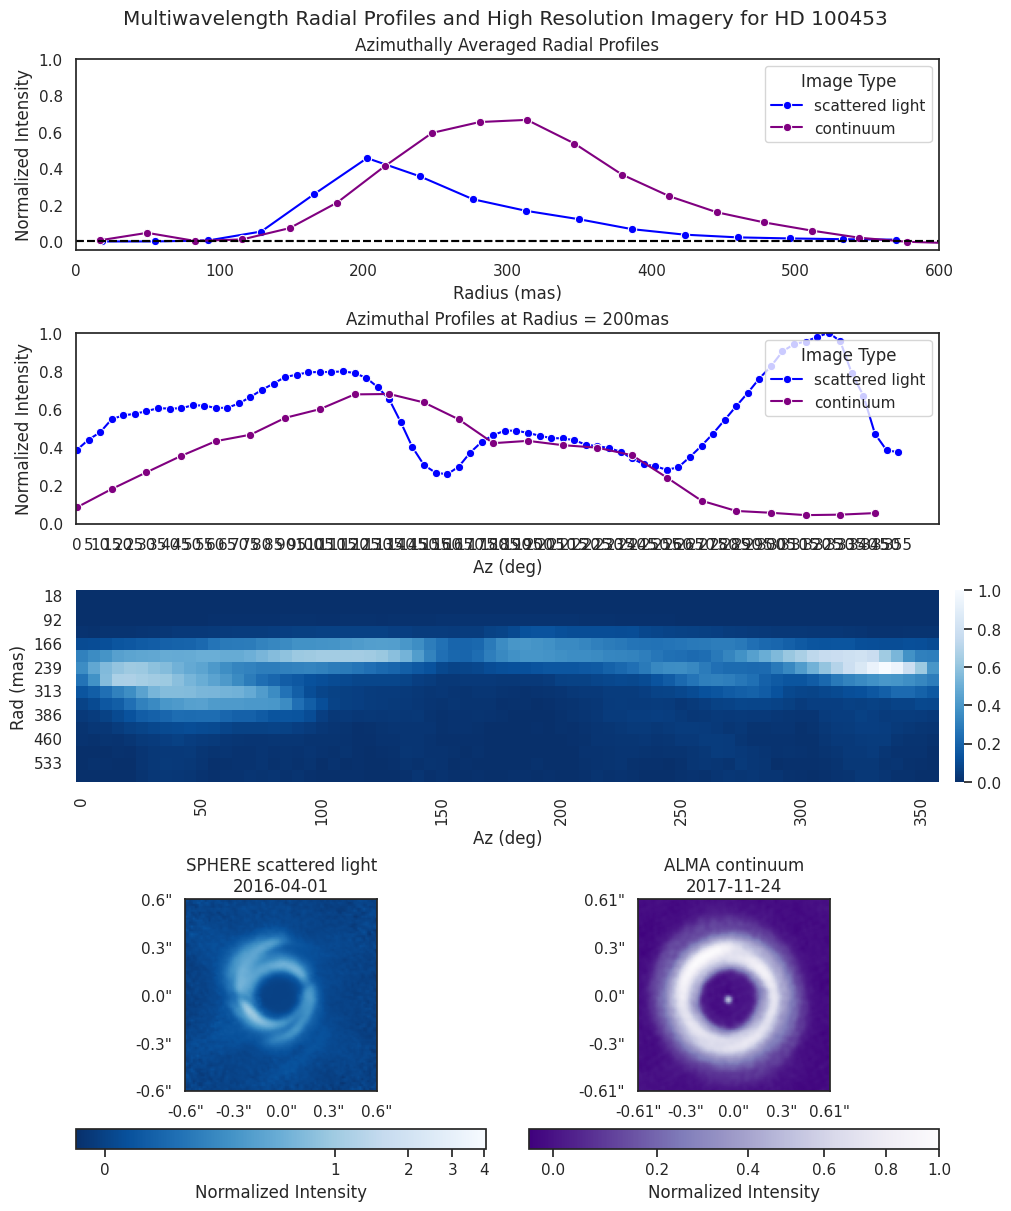

In [ ]:
dict_HD_100453 = {'sl': {'type': "scattered light",
                        'source':'SPHERE',
                        'path':'HD100453_SPHERE_2016-04-01_J.fits',
                        'trim':np.nan,
                        'stokes_component':"Q_phi",
                        'zoom':100,
                        'r2' : True,
                        'background_sub':True,
                        'sigma_clip' : 3.0,
                        'override_center': None,
                        'plot_types': ['heatmap'],
                        'plot':False,
                        'PAs': np.arange(0,360,5).tolist(), #[0,45,90,135,180,225,270,315,360],
                        'radstep': 100, #+ [145],
                        'radlist': ['200'],#[str(item) for item in np.arange(100,500,100)],
                        'PA': 149,
                        'incl': 30,
                        'dist (pc)': 10,
                        'n_start': None,
                        'n_deltas':3,
                        'delta_lim': 0.01,
                        'show_deltas': False,
                        'asinh_a': 0.05,
                        'perc_interval':(60,100),
                        'cmap': 'Blues_r',
                        'color' : 'blue'},
                  'mm': {'type': "continuum",
                         'source':'ALMA',
                         'path':'member.uid___A001_X1296_X61b.hd100453_sci.spw19_21_23_25.cont.I.pbcor.fits',
                         'trim':np.nan,
                         'stokes_component':np.nan,
                         'zoom':None,
                         'r2' : False,
                         'background_sub':False,
                         'sigma_clip' : 3.0,
                         'override_center': None,
                         'plot':False,
                         'plot_types':['az'],
                         'PAs': np.arange(0,360,15).tolist(), #[0,45,90,135,180,225,270,315,360],
                         'radstep': 100, #+ [145],
                         'radlist': ['200'],#[str(item) for item in np.arange(400,601,100)],
                         'PA': 149,
                         'incl': 30,
                         'dist (pc)': 10,
                         'n_start': 5,
                         'n_deltas':3,
                         'show_deltas': False,
                         'asinh_a': 0.5,
                         'perc_interval':(0,100),
                         'delta_lim': 0.00005,
                         'cmap': 'Purples_r',
                         'color' : 'purple'},
                  'line': None
                  }

display_dict_HD_100453 = {'zoom':600, 'autobound':False}
disk_HD_100453 = astro_object("HD 100453", dict_HD_100453,display_dict_HD_100453)
disk_HD_100453.make_plot_multiline()